In [1]:
# Cell 1: Imports & path setup
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

# Ensure we can import download_stock_data
sys.path.append(os.path.abspath(os.path.join("..", "src")))

from data.download_data import download_stock_data

In [2]:
# Cell 2: Choose a ticker and date range
ticker = "TSLA"
start_date = "2024-01-01"
end_date   = "2024-06-30"

# Download (or read from CSV if already saved)
df = download_stock_data(ticker, start_date, end_date, save_csv=True)

# If CSV exists already, you can also load directly:
# df = pd.read_csv(f"data/raw/{ticker}.csv", parse_dates=["Date"])

# Quick check
df.head()

📥 Downloading TSLA from Polygon.io...
[✓] Saved to data/raw/TSLA.csv


,Date,Open,High,Low,Close,Volume
0,2024-01-02 05:00:00,250.08,251.2500,244.4100,248.42,104654163.0
1,2024-01-03 05:00:00,244.98,245.6800,236.3200,238.45,121082599.0
2,2024-01-04 05:00:00,239.25,242.7000,237.7300,237.93,102618283.0
3,2024-01-05 05:00:00,236.86,240.1196,234.9001,237.49,92488939.0
4,2024-01-08 05:00:00,236.14,241.2500,235.3000,240.45,85163330.0


In [3]:
# Cell 3: Calculate short and long moving averages
# Typical choice: short = 20-day MA, long = 50-day MA
df["MA_short"] = df["Close"].rolling(window=20).mean()
df["MA_long"]  = df["Close"].rolling(window=50).mean()

# Drop rows where MAs aren’t yet defined
df.dropna(subset=["MA_short", "MA_long"], inplace=True)

# Preview
df[["Date", "Close", "MA_short", "MA_long"]].head()

,Date,Close,MA_short,MA_long
49,2024-03-13 04:00:00,169.48,189.8455,200.4288
50,2024-03-14 04:00:00,162.50,188.5350,198.7104
51,2024-03-15 04:00:00,163.57,186.6910,197.2128
52,2024-03-18 04:00:00,173.80,185.3835,195.9302
53,2024-03-19 04:00:00,171.32,184.2615,194.6068


In [4]:
# Cell 4: Create columns for signals
# When MA_short crosses above MA_long → buy (1)
# When MA_short crosses below MA_long → sell (-1)
# Otherwise → 0 (hold)

df["signal"] = 0
df.loc[df["MA_short"] > df["MA_long"], "signal"] = 1
df.loc[df["MA_short"] < df["MA_long"], "signal"] = -1

# To avoid “whipsaws,” we’ll only take the signal when the crossover happens:
df["position"] = df["signal"].diff()  # 1 → buy, -2 or -1 → sell

# Filter to only the actual cross events:
buys  = df[df["position"] == 2]   # short MA just crossed above long MA
sells = df[df["position"] == -2]  # short MA just crossed below long MA

# (Note: because signal changes from -1 to +1 = diff of 2; and +1 to -1 = -2)

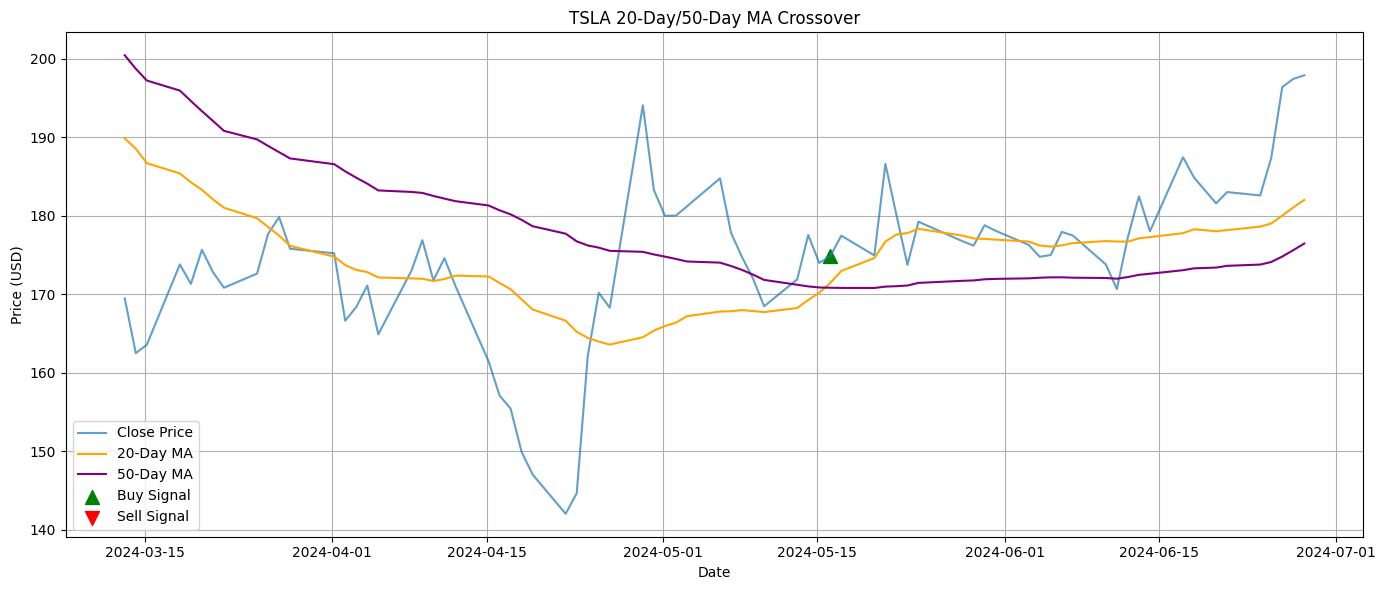

In [5]:
# Cell 5: Plot Close price, MAs, and markers for buy/sell
plt.figure(figsize=(14, 6))
plt.plot(df["Date"], df["Close"],  label="Close Price", alpha=0.7)
plt.plot(df["Date"], df["MA_short"], label="20-Day MA", color="orange")
plt.plot(df["Date"], df["MA_long"],  label="50-Day MA", color="purple")

# Mark buy points
plt.scatter(buys["Date"], buys["Close"], marker="^", color="green", s=100, label="Buy Signal")
# Mark sell points
plt.scatter(sells["Date"], sells["Close"], marker="v", color="red",   s=100, label="Sell Signal")

plt.title(f"{ticker} 20-Day/50-Day MA Crossover")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Cell 6: Simple backtest—track returns if we buy at next open after signal

df.reset_index(drop=True, inplace=True)
df["trade_price"] = df["Close"].shift(-1)  # assume we buy/sell at next day's Close for simplicity

# Create a column for strategy returns
df["returns"] = df["Close"].pct_change()  # daily market return
df["strategy_returns"] = 0.0

# Apply returns only when in “long” position
in_position = False
for i in range(1, len(df)):
    if df.loc[i-1, "position"] == 2:   # buy
        in_position = True
    elif df.loc[i-1, "position"] == -2:  # sell
        in_position = False

    if in_position:
        df.loc[i, "strategy_returns"] = df.loc[i, "returns"]

# Compute cumulative returns
df["cum_market"]   = (1 + df["returns"]).cumprod() - 1
df["cum_strategy"] = (1 + df["strategy_returns"]).cumprod() - 1

# Display the last few rows
df[["Date", "Close", "signal", "position", "returns", "strategy_returns", "cum_market", "cum_strategy"]].tail()

,Date,Close,signal,position,returns,strategy_returns,cum_market,cum_strategy
70,2024-06-24 04:00:00,182.58,1,0.0,-0.002350,-0.002350,0.077295,0.044269
71,2024-06-25 04:00:00,187.35,1,0.0,0.026126,0.026126,0.105440,0.071551
72,2024-06-26 04:00:00,196.37,1,0.0,0.048145,0.048145,0.158662,0.123141
73,2024-06-27 04:00:00,197.42,1,0.0,0.005347,0.005347,0.164857,0.129147
74,2024-06-28 04:00:00,197.88,1,0.0,0.002330,0.002330,0.167571,0.131778


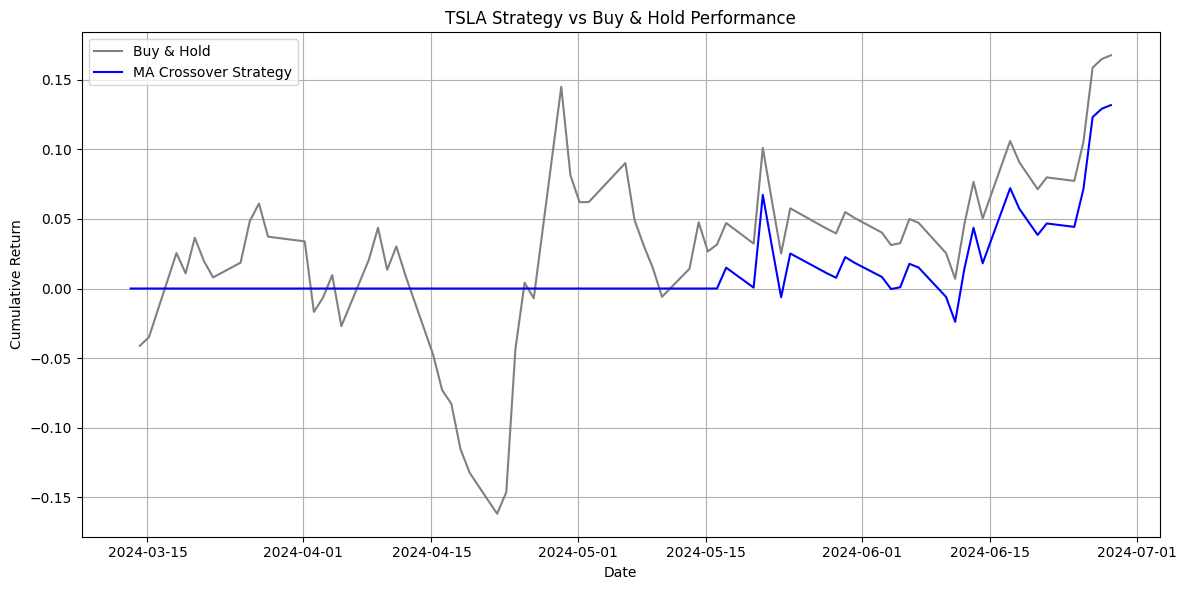

In [7]:
# Cell 7: Plot cumulative returns for both
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["cum_market"],   label="Buy & Hold", color="gray")
plt.plot(df["Date"], df["cum_strategy"], label="MA Crossover Strategy", color="blue")
plt.title(f"{ticker} Strategy vs Buy & Hold Performance")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()